# Text Decoding from GPT-2 using Beam Search

## Adding a hardware accelerator
Go to the menu and add a GPU as follows:

`Edit > Notebook Settings > Hardware accelerator > (GPU)`

Run the following cell to confirm that the GPU is detected.

In [ ]:
import torch

# Confirm that the GPU is detected
assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")

Found device: Tesla T4, n_gpu: 1


## Installing Hugging Face's Transformers and Additional Libraries
Hugging Face's Transformers (https://github.com/huggingface/transformers) will be used.

Run the following cell to install Hugging Face's Transformers library and some other useful tools. This cell will also download data which is used later.

In [ ]:
!pip install -q transformers==4.17.0  rich[jupyter]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 25.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.4 MB/s eta 0:00:00


## Beam Search
The objective is to explore decoding from a pretrained GPT-2 model using beam search. Run the below cell to set up some beam search utilities.

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

# Beam Search

def init_beam_search(model, input_ids, num_beams):
    assert len(input_ids.shape) == 2
    beam_scores = torch.zeros(num_beams, dtype=torch.float32, device=model.device)
    beam_scores[1:] = -1e9 # Break ties in first round.
    new_input_ids = input_ids.repeat_interleave(num_beams, dim=0).to(model.device)
    return new_input_ids, beam_scores


def run_beam_search_(model, tokenizer, input_text, num_beams=5, num_decode_steps=10, score_processors=[], to_cpu=True):

    input_ids = tokenizer.encode(input_text, return_tensors='pt')

    input_ids, beam_scores = init_beam_search(model, input_ids, num_beams)

    token_scores = beam_scores.clone().view(num_beams, 1)

    model_kwargs = {}
    for i in range(num_decode_steps):
        model_inputs = model.prepare_inputs_for_generation(input_ids, **model_kwargs)
        outputs = model(**model_inputs, return_dict=True)

        next_token_logits = outputs.logits[:, -1, :]
        vocab_size = next_token_logits.shape[-1]
        this_token_scores = torch.log_softmax(next_token_logits, -1)

        # Process token scores.
        processed_token_scores = this_token_scores
        for processor in score_processors:
            processed_token_scores = processor(input_ids, processed_token_scores)

        # Update beam scores.
        next_token_scores = processed_token_scores + beam_scores.unsqueeze(-1)

        # Reshape for beam-search.
        next_token_scores = next_token_scores.view(num_beams * vocab_size)

        # Find top-scoring beams.
        next_token_scores, next_tokens = torch.topk(
            next_token_scores, num_beams, dim=0, largest=True, sorted=True
        )

        # Transform tokens since we reshaped earlier.
        next_indices = torch.div(next_tokens, vocab_size, rounding_mode="floor") # This is equivalent to `next_tokens // vocab_size`
        next_tokens = next_tokens % vocab_size

        # Update tokens.
        input_ids = torch.cat([input_ids[next_indices, :], next_tokens.unsqueeze(-1)], dim=-1)

        # Update beam scores.
        beam_scores = next_token_scores

        # Update token scores.

        # UNCOMMENT: To use original scores instead.
        # token_scores = torch.cat([token_scores[next_indices, :], this_token_scores[next_indices, next_tokens].unsqueeze(-1)], dim=-1)
        token_scores = torch.cat([token_scores[next_indices, :], processed_token_scores[next_indices, next_tokens].unsqueeze(-1)], dim=-1)

        # Update hidden state.
        model_kwargs = model._update_model_kwargs_for_generation(outputs, model_kwargs, is_encoder_decoder=False)
        model_kwargs["past"] = model._reorder_cache(model_kwargs["past"], next_indices)

    def transfer(x):
        return x.cpu() if to_cpu else x

    return {
        "output_ids": transfer(input_ids),
        "beam_scores": transfer(beam_scores),
        "token_scores": transfer(token_scores)
    }


def run_beam_search(*args, **kwargs):
    with torch.inference_mode():
        return run_beam_search_(*args, **kwargs)


# Add support for colored printing and plotting.

from rich import print as rich_print

import numpy as np

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm

RICH_x = np.linspace(0.0, 1.0, 50)
RICH_rgb = (matplotlib.colormaps.get_cmap(plt.get_cmap('RdYlBu'))(RICH_x)[:, :3] * 255).astype(np.int32)[range(5, 45, 5)]


def print_with_probs(words, probs, prefix=None):
  def fmt(x, p, is_first=False):
    ix = int(p * RICH_rgb.shape[0])
    r, g, b = RICH_rgb[ix]
    if is_first:
      return f'[bold rgb(0,0,0) on rgb({r},{g},{b})]{x}'
    else:
      return f'[bold rgb(0,0,0) on rgb({r},{g},{b})] {x}'
  output = []
  if prefix is not None:
    output.append(prefix)
  for i, (x, p) in enumerate(zip(words, probs)):
    output.append(fmt(x, p, is_first=i == 0))
  rich_print(''.join(output))

# DEMO

# Show range of colors.

for i in range(RICH_rgb.shape[0]):
  r, g, b = RICH_rgb[i]
  rich_print(f'[bold rgb(0,0,0) on rgb({r},{g},{b})]hello world rgb({r},{g},{b})')

# Example with words and probabilities.

words = ['the', 'brown', 'fox']
probs = [0.14, 0.83, 0.5]
print_with_probs(words, probs)

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

hello world rgb(215,49,39)

hello world rgb(244,111,68)

hello world rgb(253,176,99)

hello world rgb(254,226,147)

hello world rgb(251,253,196)

hello world rgb(217,239,246)

hello world rgb(163,210,229)

hello world rgb(108,164,204)

the brown fox

## Token generation
The cell below produces a sequence of tokens using beam search and the provided prefix.

In [ ]:
num_beams = 5
num_decode_steps = 10
input_text = 'The brown fox jumps'

beam_output = run_beam_search(model, tokenizer, input_text, num_beams=num_beams, num_decode_steps=num_decode_steps)
for i, tokens in enumerate(beam_output['output_ids']):
    score = beam_output['beam_scores'][i]
    print(i, round(score.item() / tokens.shape[-1], 3), tokenizer.decode(tokens, skip_special_tokens=True))


0 -1.106 The brown fox jumps out of the fox's mouth, and the fox
1 -1.168 The brown fox jumps out of the fox's cage, and the fox
2 -1.182 The brown fox jumps out of the fox's mouth and starts to run
3 -1.192 The brown fox jumps out of the fox's mouth and begins to lick
4 -1.199 The brown fox jumps out of the fox's mouth and begins to bite


As another example, the cell below uses the same prefix as above and generates 3 tokens with a beam size of 4, and then prints out the **third most probable** output sequence found during the search.

In [ ]:
input_text = 'The brown fox jumps'

beam_output = run_beam_search(model, tokenizer, input_text, num_beams=4, num_decode_steps=3)

score = beam_output['beam_scores'][2]
tokens = beam_output['output_ids'][2]
print(2, round(score.item() / tokens.shape[-1], 3), tokenizer.decode(tokens, skip_special_tokens=True))

2 -0.627 The brown fox jumps up and down


Run the cell below to visualize the probabilities the model assigns for each generated word when using beam search with beam size 1 (i.e., greedy decoding).

Visualizeation with plot:


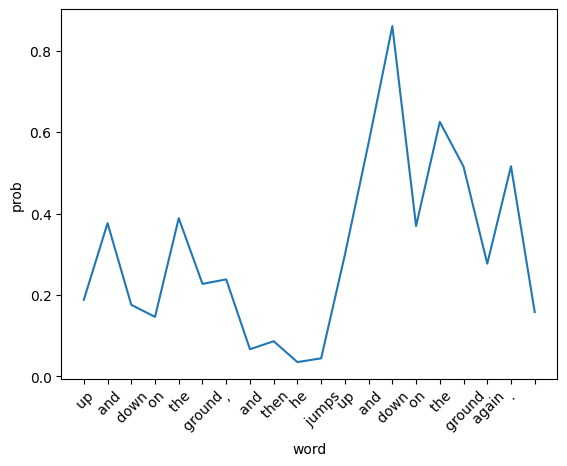

Visualization with colored text (red for lower probability, and blue for higher):


The  brown  fox  jumps up  and  down  on  the  ground ,  and  then  he  jumps  up  and  down  on  the  ground  
again . 

In [ ]:
input_text = 'The brown fox jumps'
beam_output = run_beam_search(model, tokenizer, input_text, num_beams=1, num_decode_steps=20)
probs = beam_output['token_scores'][0, 1:].exp()
output_subwords = [tokenizer.decode(tok, skip_special_tokens=True) for tok in beam_output['output_ids'][0]]

print('Visualizeation with plot:')

fig, ax = plt.subplots()
plt.plot(range(len(probs)), probs)
ax.set_xticks(range(len(probs)))
ax.set_xticklabels(output_subwords[-len(probs):], rotation = 45)
plt.xlabel('word')
plt.ylabel('prob')
plt.show()

print('Visualization with colored text (red for lower probability, and blue for higher):')

print_with_probs(output_subwords[-len(probs):], probs, ' '.join(output_subwords[:-len(probs)]))

Observe that the model assign higher probability to tokens generated later than to tokens generated earlier. This is because at the early stage, the model has seen only a few words. For instance, while generating the first word "up", the model knows only 4 words that come before it i.e. "The brown fox jumps".

Whereas, for the tokens generated later, the model has knowledge of more words as compared to the previous case. For example, when the word "down" is generated for the 2nd time, the model knows about a lot of words that were generated before i.e. "The  brown  fox  jumps up  and  down  on  the  ground ,  and  then  he  jumps  up  and".

Due to this reason, higher probability is assigned to tokens generated later than to tokens generated earlier because for tokens generated later, the model has more context about the sequence of tokens that come before it.



Run the cell below to visualize the word probabilities when using different beam sizes.

Visualization with plot:


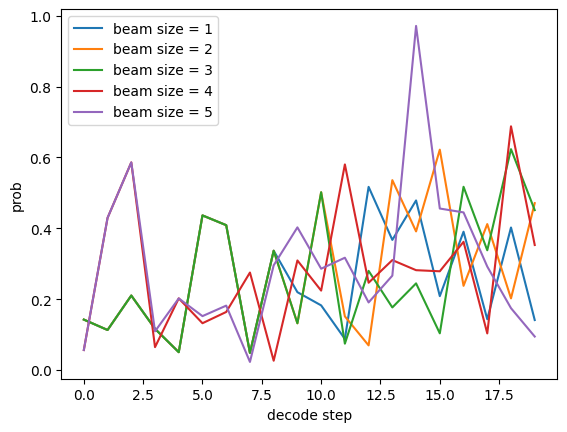

In [ ]:
input_text = 'Once upon a time, in a barn near a farm house,'
num_decode_steps = 20
model.cuda()

beam_size_list = [1, 2, 3, 4, 5]
output_list = []
probs_list = []
for bm in beam_size_list:
  beam_output = run_beam_search(model, tokenizer, input_text, num_beams=bm, num_decode_steps=num_decode_steps)
  output_list.append(beam_output)
  probs = beam_output['token_scores'][0, 1:].exp()
  probs_list.append((bm, probs))

print('Visualization with plot:')
fig, ax = plt.subplots()
for bm, probs in probs_list:
  plt.plot(range(len(probs)), probs, label=f'beam size = {bm}')
plt.xlabel('decode step')
plt.ylabel('prob')
plt.legend(loc='best')
plt.show()

print('Model predictions:')
for bm, beam_output in zip(beam_size_list, output_list):
  tokens = beam_output['output_ids'][0]
  print(bm, beam_output['beam_scores'][0].item() / tokens.shape[-1], tokenizer.decode(tokens, skip_special_tokens=True))

## Avoiding Repetition in Beam Search

Beam search often results in repetition in the predicted tokens. In the following cell, a score processor called `WordBlock` is passed to `run_beam_search`. At each time step, it reduces the probability for any previously seen word so that it is not generated again.

Run the cell to see how the output of beam search changes with and without using `WordBlock`.

In [ ]:
import collections

class WordBlock:
    def __call__(self, input_ids, scores):
        for batch_idx in range(input_ids.shape[0]):
            for x in input_ids[batch_idx].tolist():
                scores[batch_idx, x] = -1e9
        return scores

input_text = 'Once upon a time, in a barn near a farm house,'
num_beams = 1

print('Beam Search')
beam_output = run_beam_search(model, tokenizer, input_text, num_beams=num_beams, num_decode_steps=40, score_processors=[])
print(tokenizer.decode(beam_output['output_ids'][0], skip_special_tokens=True))

print('Beam Search w/ Word Block')
beam_output = run_beam_search(model, tokenizer, input_text, num_beams=num_beams, num_decode_steps=40, score_processors=[WordBlock()])
print(tokenizer.decode(beam_output['output_ids'][0], skip_special_tokens=True))


Model predictions:
1 -0.9706197796445905 Once upon a time, in a barn near a farm house, a young boy was playing with a stick. He was playing with a stick, and the boy was
2 -0.9286185177889738 Once upon a time, in a barn near a farm house, a young boy was playing with a stick. The boy was playing with a stick, and the boy
3 -0.9597567933978457 Once upon a time, in a barn near a farm house, a young boy was playing with a stick. The boy, who had been playing with a stick,
4 -0.9205130952777285 Once upon a time, in a barn near a farm house, there was a young girl who had been brought up by her mother. She had been brought up by
5 -0.9058780092181582 Once upon a time, in a barn near a farm house, there was a man who had been living in the house for a long time. He was a man
Beam Search
Once upon a time, in a barn near a farm house, a young boy was playing with a stick. He was playing with a stick, and the boy was playing with a stick. The boy was playing with a stick, and the boy was playi

Even though `WordBlock` avoids generation of seen words, it is not a practical way to prevent repetition in beam search due to the following reasons :-

1.   Even though repetition is undesirable sometimes, there are cases where repetition is needed but WordBlock will strictly avoid repetition even in these scenarios. For instance, in the code above that demonstrates WordBlock, the model incorrectly generated "the young girl" instead of "a young girl" because the article "a" is already present in the input. And later, the model does not generate correct pronouns (he instead of she) because the correct pronoun has been generated before and Wordblock penalizes the correct pronoun. This results in less fluent and grammatically incorrect outputs.

2.   Incorporating WordBlock into beam search introduces an additional computational cost. The decoder needs to check and apply the penalty for each generated token, which can increase the decoding time.

3. WordBlock is sensitive to the penalty value (1e-9 in the code above). Setting a very high penalty excessively discourages repetition and results in ungrammatical and incoherent output. On the other hand, setting a low penalty may have zero impact on preventing repetition.




## BeamBlock vs WordBlock

In the following cell, the previous `WordBlock` example is used to write a new score processor called `BeamBlock`. Instead of uni-grams, `BeamBlock` implementation prevents tri-grams from appearing more than once in the sequence.

Note: This technique is called "beam blocking" and is described [here](https://arxiv.org/pdf/1705.04304.pdf) (section 2.5). Note that here the output distribution is not re-normalized after masking values, although typically re-normalization is done.

In [ ]:
import collections

class BeamBlock:
    def __call__(self, input_ids, scores):
        for batch_idx in range(input_ids.shape[0]):
            # WRITE YOUR CODE HERE!
            sent = input_ids[batch_idx].tolist()
            for i in range(2, len(sent)):
                if(sent[i-2]==sent[-2] and sent[i-1]==sent[-1]):
                    scores[batch_idx, sent[i]] = -1e9

        return scores

input_text = 'Once upon a time, in a barn near a farm house,'
num_beams = 1

print('Beam Search')
beam_output = run_beam_search(model, tokenizer, input_text, num_beams=num_beams, num_decode_steps=40, score_processors=[])
outText = tokenizer.decode(beam_output['output_ids'][0], skip_special_tokens=True)
print(outText[:int(len(outText)/2)], "\n", outText[int(len(outText)/2):])

print('Beam Search w/ Beam Block')
beam_output = run_beam_search(model, tokenizer, input_text, num_beams=num_beams, num_decode_steps=40, score_processors=[BeamBlock()])
outText = tokenizer.decode(beam_output['output_ids'][0], skip_special_tokens=True)
print(outText[:int(len(outText)/2)], "\n", outText[int(len(outText)/2):])


Beam Search
Once upon a time, in a barn near a farm house, a young boy was playing with a stick. He was playing with a s 
 tick, and the boy was playing with a stick. The boy was playing with a stick, and the boy was playing with a
Beam Search w/ Beam Block
Once upon a time, in a barn near a farm house, a young boy was playing with a stick. He was playing on the 
  stick, and the boy was trying to get a ball. The boy was holding the stick in his hand, and he was trying
